## TFIM with Periodic Boundry

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
import time

### Basis

In [2]:
def createBasis(N,total):
    assert abs(total) <= N/2 , "Magnetisation exceeds maximum"
    assert total%1 == N%2 / 2 , "No combinations possible "
    
    n_extra = int(2*total)
    n_pair = int((N-n_extra)/2)
    n_states = int(sp.special.comb(N,n_pair + n_extra))
    
    states = set(itertools.permutations("1"*(n_pair+n_extra) + "0"*(n_pair)))
    #print(*states,sep = "\n")
    
    states = np.array([int(str.join("",s),2) for s in states])
    states.sort()
    
    return states

In [3]:
def createBasis_gosper(N,total):
    assert abs(total) <= N/2 , "Magnetisation exceeds maximum"
    assert total%1 == N%2 / 2 , "No combinations possible "

    if(total == N/2):
        return [2**N - 1]
    if(total == -N/2):
        return [0]
    
    n_extra = int(2*total)
    n_pair = int((N-n_extra)/2)

    states = []
    # --- Gosper's hack ---
    x = (1<<(n_pair + n_extra)) - 1

    limit = 1<<N
    while x < 2**N:
        states.append(x)
        # Gosper's hack to get next integer with same number of 1s
        c = x & -x
        r = x + c
        x = (((r ^ x) >> 2) // c) | r
        
    states.sort()

    assert len(states) == sp.special.comb(N,n_pair)
    return states

In [4]:
N,total = 8,4
# Test runtime
start = time.time()
states_gosper = createBasis_gosper(N,total)
t1 = time.time()
states_comb = createBasis(N,total)
t2 = time.time()
print("Gosper runtime:", t1 - start)
print("Combin runtime:",t2 - t1)
print("Number of states:", len(states_gosper),len(states_gosper) == len(states_comb))


Gosper runtime: 0.0
Combin runtime: 0.46770477294921875
Number of states: 1 True


In [5]:
#Checking if combining the generated basis for all possible energies gives the standard basis
N = 4
E = np.arange(-N/2,N/2 + 1,1)
bases_block = []
for e in E:
    bases_block.extend(createBasis_gosper(N,e))
    bases_block.append("|")
print(bases_block)
for i in range(2**N):
    assert i in bases_block
print(True)

[0, '|', 1, 2, 4, 8, '|', 3, 5, 6, 9, 10, 12, '|', 7, 11, 13, 14, '|', 15, '|']
True


### Operator

In [6]:
def spin_z(state,index):
    return 1 if (state & (1<<index)) != 0 else -1

def spin_z_z1_closed(state,N):
    spins = np.array([1 if (state & (1<<index)) != 0 else -1 for index in range(N)])[::-1]
    return sum(np.multiply(spins[:-1],spins[1:])) + spins[0]*spins[-1]
    
#spin_z_z1_closed(6,3)   
N,E = 4,0
#states = np.arange(2**N)
states = createBasis_gosper(N,E)
dict(zip([bin(state) for state in states],[([spin_z(state,index) for index in range(N)],spin_z_z1_closed(state,N)) for state in states]));

### Hamiltonian

In [7]:
def hamiltonian_periodicBoundry(J = 1,g = 0,N = 3):
    '''
    Returns: Dictionary of energies and corresponding diagonal array
    '''
    assert g == 0

    E = np.arange(-N/2, N/2 + 1,1)    
    states = dict(zip(E,[createBasis_gosper(N,e) for e in E]))
    
    H = {}
    for e in E:
        H[e] = np.diag([-J*spin_z_z1_closed(state,N) for state in states[e]])
        
    return H

In [8]:
hamiltonian_periodicBoundry(J = 1,N = 4);

### Ground State Energy

In [20]:
J,N = [-1,1],12

H_pos = hamiltonian_periodicBoundry(J = J[1],N = N)
H_neg = hamiltonian_periodicBoundry(J = J[0],N = N)

gs_1 = {e:sp.sparse.linalg.eigsh(h,k = 1,which='SA',return_eigenvectors=False) for e,h in H_pos.items()}
gs_2 = {e:sp.sparse.linalg.eigsh(h,k = 1,which='SA',return_eigenvectors=False) for e,h in H_neg.items()}
#gs = {e: min(np.linalg.eigvalsh(h)) for e,h in H.items()}

gs_1,gs_2;

C:\Users\Pradyumna\AppData\Local\Temp\ipykernel_17576\3053093318.py:6: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  gs_1 = {e:sp.sparse.linalg.eigsh(h,k = 1,which='SA',return_eigenvectors=False) for e,h in H_pos.items()}
C:\Users\Pradyumna\AppData\Local\Temp\ipykernel_17576\3053093318.py:7: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  gs_2 = {e:sp.sparse.linalg.eigsh(h,k = 1,which='SA',return_eigenvectors=False) for e,h in H_neg.items()}


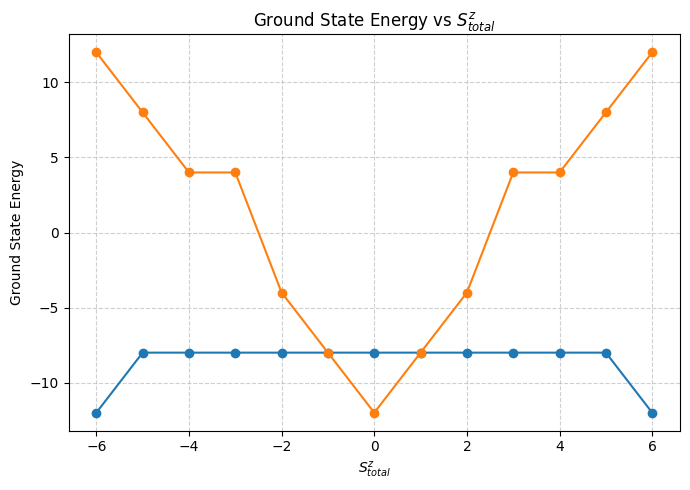

In [21]:
keys = list(gs_1.keys())
values_1 = [gs_1[k] for k in keys]
values_2 = [gs_2[k] for k in keys]
# Plot
plt.figure(figsize=(7,5))

plt.plot(keys,values_1, marker='o', linestyle='-', label = f'J = {J[1]}')
plt.plot(keys,values_2, marker='o', linestyle='-', label = f'J = {J[0]}')

plt.title("Ground State Energy vs $S^z_{total}$")
plt.xlabel("$S^z_{total}$")
plt.ylabel("Ground State Energy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()